<a href="https://colab.research.google.com/github/manmeet3591/kaggle_experiments/blob/main/geospatial/Multi_label_Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-label Land Cover Classification with Deep Learning


Multi-label land cover classification is less explored compared to single-label classifications. In contrast, multi-label classifications are more realistic as we always find out multiple land cover in each image. However, with the Deep learning applications and Convolutional Neural Networks, we can tackle the challenge of multilabel classifications.


In this tutorial, we use the redesigned Multi-label UC Merced dataset with 18 land cover classes. UC Merced Land use dataset was originally introduced as one of the earliest satellite datasets for computer vision. In fact, the UC Merced dataset is considered the MNIST of satellite image dataset. The original dataset consisted of 21 classes of single-label classification.

### Getting Data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import CSVLogger, SaveModelCallback
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [3]:
!wget https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
!unzip UCMercedLanduse.zip


--2021-11-14 07:02:44--  https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip [following]
--2021-11-14 07:02:44--  https://www.dropbox.com/s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1c45a1917e052f6d27ef5f7a6f.dl.dropboxusercontent.com/cd/0/inline/BZ-4iYUD_pCoe8lrLBII63H6qufITG_ORFdYO0yE6jiXfWbDx-kJhASpObFteiALJ-qV9eEmyQ1VfTzLwnLVkC1cwRfsjfLHHUgqus9d4ZkyvRoiQMYUFWnVrVup442EexbOy-QLcAc9OUwG4rnlCToc/file# [following]
--2021-11-14 07:02:44--  https://uc1c45a1917e052f6d27ef5f7a6f.dl.dropboxusercontent.com/cd/0/inline/BZ-4iYUD_pCoe8lrLBII63H6qufITG_ORFdYO0yE6jiXfWbDx-kJhASpObFteiALJ-qV

In [4]:
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")
df.head()

,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [5]:
df.shape

(2100, 18)

In [6]:
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)
class_count

,class,Count
1,airplane,100
2,bare-soil,718
3,buildings,691
4,cars,886
5,chaparral,115
6,court,105
7,dock,100
8,field,103
9,grass,975
10,mobile-home,102


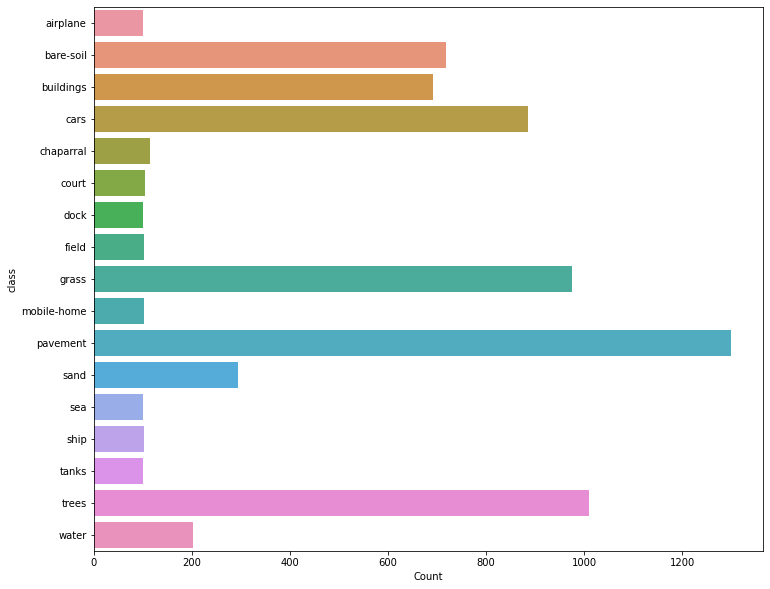

In [7]:
fig, ax= plt.subplots(figsize=(12,10))
sns.barplot(y="class", x="Count",  data=class_count, ax=ax);

In [8]:
list(class_count['class'])

['airplane',
 'bare-soil',
 'buildings',
 'cars',
 'chaparral',
 'court',
 'dock',
 'field',
 'grass',
 'mobile-home',
 'pavement',
 'sand',
 'sea',
 'ship',
 'tanks',
 'trees',
 'water']

### Training 

In [9]:
path =  Path("UCMerced")
data_src = (ImageList.from_df(df=df, path=path, folder='images', suffix=".tif")
            .split_by_rand_pct(0.2)
            
            .label_from_df(cols=list(class_count['class']), label_cls=MultiCategoryList, one_hot=True))

In [10]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
data = (data_src.transform(tfms, size=256).databunch().normalize(imagenet_stats))

In [12]:
data.c

17

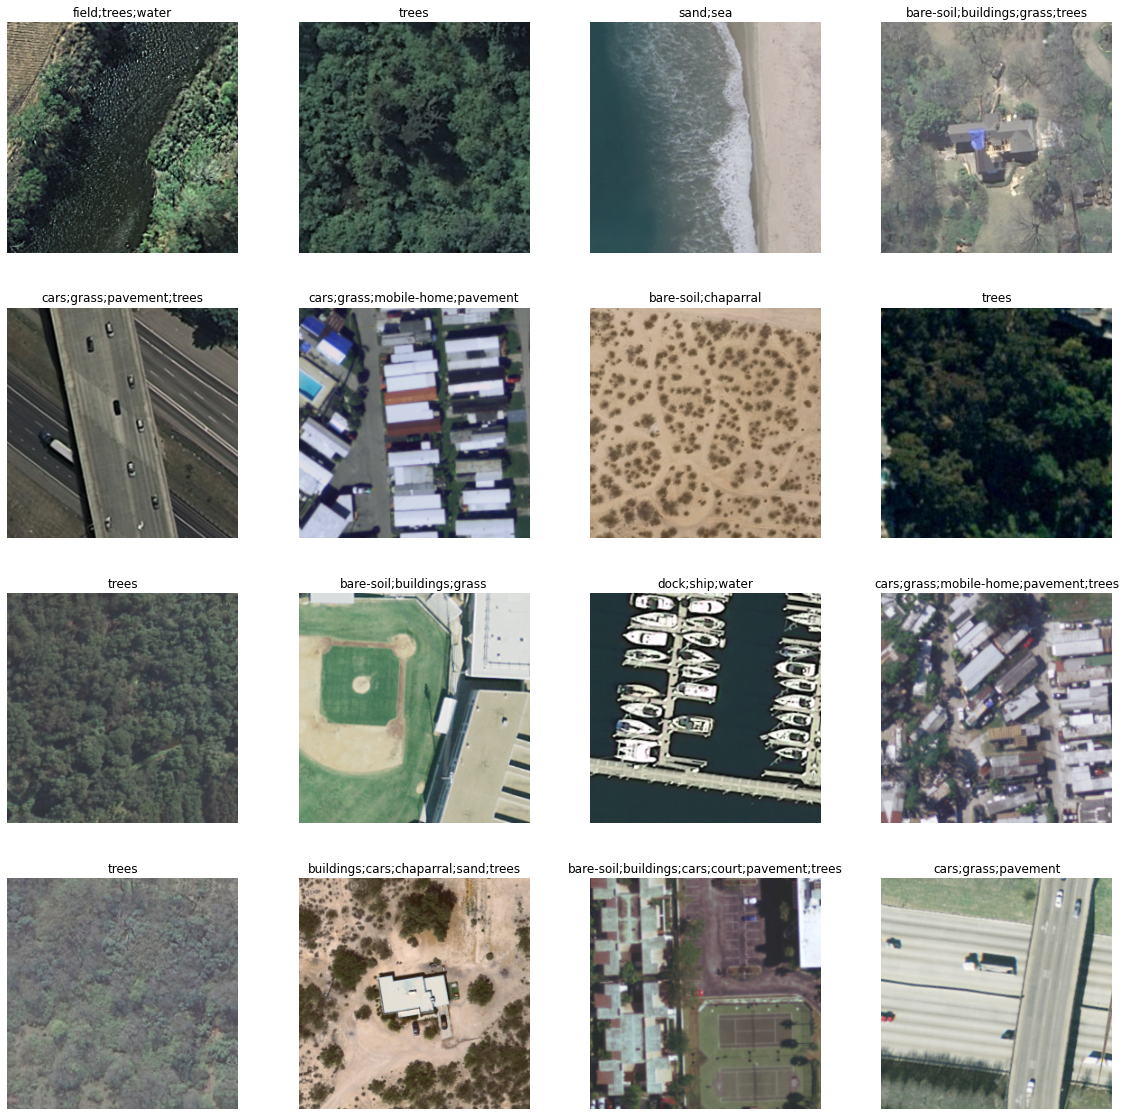

In [13]:
data.show_batch(4)

In [14]:
f_score = partial(fbeta, thresh=0.45)
learn = cnn_learner(data, models.resnet34, metrics=[accuracy_thresh, f_score],
                    callback_fns=[ShowGraph, SaveModelCallback])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


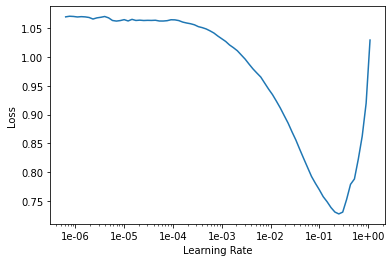

In [16]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.754578,0.437827,0.816667,0.767262,00:07
1,0.437715,0.130262,0.945798,0.884113,00:07
2,0.279630,0.104904,0.955742,0.907306,00:07
3,0.202148,0.097265,0.960924,0.921558,00:07
4,0.159592,0.096096,0.959524,0.912999,00:07


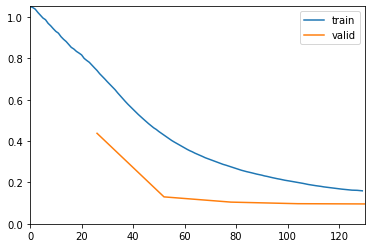

Better model found at epoch 0 with valid_loss value: 0.4378266930580139.
Better model found at epoch 1 with valid_loss value: 0.1302623152732849.
Better model found at epoch 2 with valid_loss value: 0.10490402579307556.
Better model found at epoch 3 with valid_loss value: 0.09726545214653015.
Better model found at epoch 4 with valid_loss value: 0.09609632194042206.


In [17]:
learn.fit_one_cycle(5, 1e-2)

In [18]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


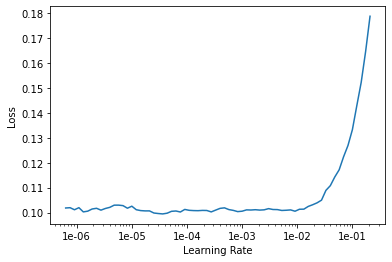

In [19]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.105348,0.094116,0.961064,0.914390,00:07
1,0.101862,0.093654,0.959244,0.912614,00:07
2,0.099202,0.090778,0.962185,0.914047,00:07
3,0.095459,0.090845,0.961064,0.922071,00:07
4,0.092711,0.090240,0.961345,0.923383,00:07


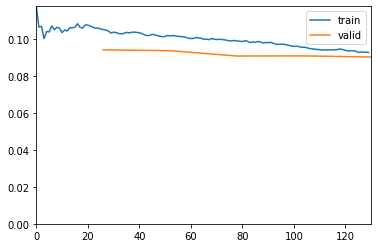

Better model found at epoch 0 with valid_loss value: 0.09411630779504776.
Better model found at epoch 1 with valid_loss value: 0.09365354478359222.
Better model found at epoch 2 with valid_loss value: 0.09077803045511246.
Better model found at epoch 4 with valid_loss value: 0.09024017304182053.


In [20]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

### Prediction

In [21]:
!wget https://www.dropbox.com/s/6tt0t61uq2w1n3s/test.zip
!unzip test.zip

--2021-11-14 07:09:52--  https://www.dropbox.com/s/6tt0t61uq2w1n3s/test.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6tt0t61uq2w1n3s/test.zip [following]
--2021-11-14 07:09:52--  https://www.dropbox.com/s/raw/6tt0t61uq2w1n3s/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc886570e48f2d0ee9e2df42ecb0.dl.dropboxusercontent.com/cd/0/inline/BZ87fvTS51iNFLimMjYT_bftozsRW7dF8YMW-XSkZskV0u8fI3TXzMtxzP0tRZVHbXwLKNyztHL-Wt5b1Xo_lYw5XtQuEQg7WeoY2t6HostM6QXsagLbB0SOMh3Q65IY2_SZk-ZdsGZc9Kex_1SZHZ8n/file# [following]
--2021-11-14 07:09:52--  https://uc886570e48f2d0ee9e2df42ecb0.dl.dropboxusercontent.com/cd/0/inline/BZ87fvTS51iNFLimMjYT_bftozsRW7dF8YMW-XSkZskV0u8fI3TXzMtxzP0tRZVHbXwLKNyztHL-Wt5b1Xo_lYw5XtQuEQg7WeoY2

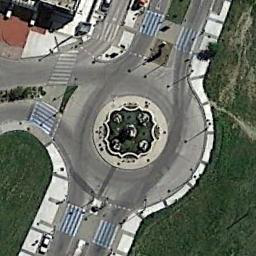

In [22]:
img = open_image("/content/test/roundabout_086.jpg")
img

In [23]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.])

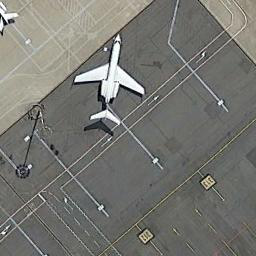

In [24]:
img = open_image("/content/test/airplane_439.jpg")
img

In [25]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])